In [17]:
import os
import json
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]
scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
tasks = scores.keys()
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)
langs = set()
for task in tasks:
    for lang_name in scores[task]:
        if "reconstructed_featural" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
# we remove all languages from score that are not in langs
for task_name in scores:
    for lang_name in list(scores[task_name].keys()):
        if lang_name not in langs:
            del scores[task_name][lang_name]
# we make a subset consisting of only the languages for which an adapter exists
scores_subset = {}
no_adapter = {}
for task_name in scores:
    scores_subset[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            scores_subset[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

print("total languages:", len(langs))
for task in tasks:
    print(f"task: {task}, {len(set(scores[task]).intersection(langs))} languages")
    print(
        f"{len(set(scores_subset[task]).intersection(langs))} have a trained language adapter, {len(set(no_adapter[task]).intersection(langs))} not"
    )
    print(
        f"{len(set(xlm_included[task]).intersection(langs))} are in the xlm included languages, {len(set(xlm_not_included[task]).intersection(langs))} not"
    )
    # we make a list of all languages
all_xlm_included = set()
for task_name in xlm_included:
    all_xlm_included.update(xlm_included[task_name].keys())
all_xlm_not_included = set()
for task_name in xlm_not_included:
    all_xlm_not_included.update(xlm_not_included[task_name].keys())
print(f"total xlm included languages: {len(all_xlm_included)}")
print(f"total xlm not included languages: {len(all_xlm_not_included)}")

adapter_available = set()
for task_name in scores_subset:
    adapter_available.update(scores_subset[task_name].keys())
print(f"total languages with adapter available: {len(adapter_available)}")
print(adapter_available)
no_adapter_available = set()
for task_name in no_adapter:
    no_adapter_available.update(no_adapter[task_name].keys())
print(f"total languages without adapter available: {len(no_adapter_available)}")

total languages: 157
task: ner, 134 languages
29 have a trained language adapter, 105 not
85 are in the xlm included languages, 49 not
task: pos, 80 languages
19 have a trained language adapter, 61 not
57 are in the xlm included languages, 23 not
task: copa, 11 languages
11 have a trained language adapter, 0 not
11 are in the xlm included languages, 0 not
task: qa, 12 languages
11 have a trained language adapter, 1 not
12 are in the xlm included languages, 0 not
total xlm included languages: 87
total xlm not included languages: 70
total languages with adapter available: 30
{'ja', 'ht', 'my', 'is', 'mi', 'eu', 'sr', 'tr', 'es', 'sw', 'zh', 'mhr', 'gn', 'id', 'vi', 'cdo', 'ar', 'th', 'el', 'ilo', 'de', 'jv', 'et', 'it', 'ta', 'hi', 'xmf', 'en', 'ru', 'qu'}
total languages without adapter available: 127


In [2]:
def get_significance(task_name, option1, option2, alternative="two-sided", data=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = data.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in data[task_name]:
            if option1 in data[task_name][lang_name] and option2 in data[task_name][lang_name]:
                score1 = data[task_name][lang_name][option1]
                score2 = data[task_name][lang_name][option2]
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val


def make_boxplot(tasks, columns):
    data = []
    if tasks == "all":
        task_names = scores.keys()
    elif len(tasks) == 1:
        task_names = [tasks]
    else:
        task_names = tasks
    for task in task_names:
        for lang_name in scores[task]:
            if all(col in scores[task][lang_name] for col in columns):
                data.append([task, lang_name] + [scores[task][lang_name][col] for col in columns])
    df = pd.DataFrame(data, columns=["task", "lang_name"] + columns)
    # we divide the scores of qa by 100
    df.loc[df["task"] == "qa", columns] = df.loc[df["task"] == "qa", columns] / 100
    # we melt the dataframe to get it in the right format for seaborn
    df_melted = df.melt(id_vars=["task", "lang_name"], value_vars=columns, var_name="method", value_name="score")
    # we plot the data
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="method", y="score", data=df_melted)
    plt.title(f"Comparison of methods for {tasks}")
    plt.xlabel("Method")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
# we compare the averaging baseline to our method
tasks = ["all", "ner", "pos", "copa", "qa"]
sign = []
not_sign = []
for task in tasks:
    print(f"{task}, average vs reconstructed_featural")
    t_stat, p_val = get_significance(task, "reconstructed_featural", "baseline_avg_adapter", alternative="greater")
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append(task)
    else:
        print("The difference is not statistically significant")
        not_sign.append(task)
    print("-----------------------------------")

print("sign", sign)
print("\nnotsign", not_sign)

all, average vs reconstructed_featural
average scores
reconstructed_featural: 0.5037595015953552
baseline_avg_adapter: 0.43721141279941217
t-statistic: 15.577858201981066
p-value: 2.3077390135264786e-38
The difference is statistically significant
-----------------------------------
ner, average vs reconstructed_featural
average scores
reconstructed_featural: 0.5013399275268126
baseline_avg_adapter: 0.39532461426531496
t-statistic: 20.254865386795764
p-value: 1.2575944653491345e-42
The difference is statistically significant
-----------------------------------
pos, average vs reconstructed_featural
average scores
reconstructed_featural: 0.4679441087506307
baseline_avg_adapter: 0.45354927056693806
t-statistic: 5.738269287807531
p-value: 8.46435925409197e-08
The difference is statistically significant
-----------------------------------
copa, average vs reconstructed_featural
average scores
reconstructed_featural: 0.5498181818181818
baseline_avg_adapter: 0.5534545454545454
t-statistic: -0

In [8]:
subsets = {
    "all": scores,
    "xlm_included": xlm_included,
    "xlm_not_included": xlm_not_included,
    "no_adapter": no_adapter,
    "with adapter": scores_subset,
}
sign = []
not_sign = []
for subset_name, subset_data in subsets.items():
    print(f"{subset_name}, average vs reconstructed_featural")
    t_stat, p_val = get_significance(
        "all", "reconstructed_featural", "baseline_avg_adapter", data=subset_data, alternative="greater"
    )
    if p_val < 0.05:
        print("The difference is statistically significant")
        sign.append(subset_name)
    else:
        print("The difference is not statistically significant")
        not_sign.append(subset_name)
    print("-----------------------------------")
print("sign", sign)
print("\nnotsign", not_sign)

all, average vs reconstructed_featural
average scores
reconstructed_featural: 0.5037595015953552
baseline_avg_adapter: 0.43721141279941217
t-statistic: 15.577858201981066
p-value: 2.3077390135264786e-38
The difference is statistically significant
-----------------------------------
xlm_included, average vs reconstructed_featural
average scores
reconstructed_featural: 0.567096136484991
baseline_avg_adapter: 0.5022505291311039
t-statistic: 13.345942478080246
p-value: 2.8012564513867587e-28
The difference is statistically significant
-----------------------------------
xlm_not_included, average vs reconstructed_featural
average scores
reconstructed_featural: 0.3565687303729623
baseline_avg_adapter: 0.2860641706201284
t-statistic: 8.152644268817092
p-value: 4.78079563563415e-12
The difference is statistically significant
-----------------------------------
no_adapter, average vs reconstructed_featural
average scores
reconstructed_featural: 0.4830920749620409
baseline_avg_adapter: 0.4101752

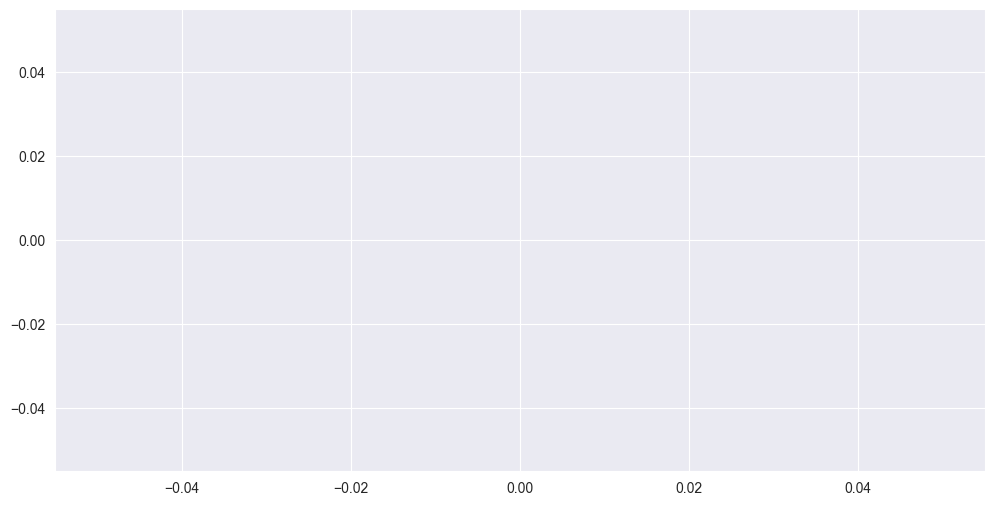

In [11]:
# For each of these subsets, we make a barplot that shows the difference between the method and the baseline


In [15]:
def get_mean_scores(task_name, option1, option2, data=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = data.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in data[task_name]:
            if option1 in data[task_name][lang_name] and option2 in data[task_name][lang_name]:
                score1 = data[task_name][lang_name][option1]
                score2 = data[task_name][lang_name][option2]
                all_scores1.append(score1)
                all_scores2.append(score2)
    return np.mean(all_scores1), np.mean(all_scores2)


differences = {}
for subset_name, subset_data in subsets.items():
    print(f"{subset_name}, average vs reconstructed_featural")
    mean_reconstructed, mean_avg = get_mean_scores(
        "all", "reconstructed_featural", "baseline_avg_adapter", data=subset_data
    )
    differences[subset_name] = mean_reconstructed - mean_avg
print(differences)

all, average vs reconstructed_featural
xlm_included, average vs reconstructed_featural
xlm_not_included, average vs reconstructed_featural
no_adapter, average vs reconstructed_featural
with adapter, average vs reconstructed_featural
{'all': np.float64(0.06654808879594304), 'xlm_included': np.float64(0.06484560735388711), 'xlm_not_included': np.float64(0.07050455975283387), 'no_adapter': np.float64(0.07291680330350342), 'with adapter': np.float64(0.051445137249442774)}
